In [2]:
# %load general_load.py
#!/usr/bin/env python3

# Imports
import csv
import math
import os, os.path
import io
import sys
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from IPython.display import display

%matplotlib inline
sb.set()

def goldilocks_temp(t):
    if t < 273:
        return -1;
    elif t > 373:
        return 1;
    else:
        return 0

csv_filename = "./Data/exoplanetarchive/candidates-20190613-TIDIED.csv"
longnames = {}
with open(csv_filename, 'r') as f:
    lines = f.readlines()
    for line in lines[8:23]:
        varname, longname = line.strip().split(':')
        varname = varname[9:].strip()
        longname = longname.replace(',', '').strip()
        #print(varname, longname)
        longnames[varname] = longname
        
dataset = pd.read_csv(csv_filename, header = 24)

goldilocks_dataset = dataset.drop(['kepid',
                                   'koi_period',
                                   'koi_period_err1',
                                   'koi_prad_err1',
                                   #'koi_insol',
                                   'koi_insol_err1', 
                                   'koi_steff',
                                   'koi_steff_err1',
                                   'koi_slogg',
                                   'koi_slogg_err1',
                                   #'koi_srad',
                                   'koi_srad_err1'],
                                  axis=1).copy()
goldilocks_dataset.head()

goldilocks_dataset["gold_temp"] = list(map(goldilocks_temp, goldilocks_dataset["koi_teq"]))
goldilocks_dataset = goldilocks_dataset.dropna()

goldX = goldilocks_dataset.drop(["kepoi_name","koi_teq","gold_temp"], axis=1)
goldY = goldilocks_dataset['gold_temp']

goldX.columns = [longnames[x] for x in goldX.columns]
goldilocks_dataset.head()

,kepoi_name,koi_prad,koi_teq,koi_insol,koi_srad,gold_temp
0,K07621.01,1.86,303.0,2.00,1.187,0
1,K00958.01,2.53,486.0,13.18,0.720,1
2,K00984.01,2.29,942.0,186.31,0.815,1
3,K04921.01,28.41,1046.0,283.07,13.056,1
4,K06253.01,1.40,531.0,18.86,0.836,1


If I'm going to be making my own colormap, I need to import the following:

In [3]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [4]:
# Make the Datasets

just_right = goldilocks_dataset[goldilocks_dataset["gold_temp"] == 0].drop("kepoi_name",axis=1).copy()
too_hot = goldilocks_dataset[goldilocks_dataset["gold_temp"] == 1].drop("kepoi_name",axis=1).copy()
too_cold = goldilocks_dataset[goldilocks_dataset["gold_temp"] == -1].drop("kepoi_name",axis=1).copy()

# Split into X and Y

jrX = just_right.drop(["koi_teq", "gold_temp"], axis=1).copy()
jrY = just_right["gold_temp"]

thX = too_hot.drop(["koi_teq", "gold_temp"], axis=1).copy()
thY = too_hot["gold_temp"]

tcX = too_cold.drop(["koi_teq", "gold_temp"], axis=1).copy()
tcY = too_cold["gold_temp"]

In [5]:
from sklearn.model_selection import train_test_split

# Splitting the hot/cold/right arrays into test and train data
hotX_train, hotX_test, hotY_train, hotY_test = train_test_split(thX, thY, random_state=1)
coldX_train, coldX_test, coldY_train, coldY_test = train_test_split(tcX, tcY, random_state=1)
rightX_train, rightX_test, rightY_train, rightY_test = train_test_split(jrX, jrY, random_state=1)

In [6]:
# Testing
testingX = pd.concat([hotX_test, coldX_test, rightX_test])
testingY = pd.concat([hotY_test, coldY_test, rightY_test])

# Training
trainingX = pd.concat([hotX_train, coldX_train, rightX_train])
trainingY = pd.concat([hotY_train, coldY_train, rightY_train])
#trainingY.head()

In [7]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(trainingX, trainingY)
#rng = np.random.RandomState(0)
Xnew = testingX
ynew = model.predict(testingX)

dim1 = "koi_prad"
dim2 = "koi_srad"
dim3 = "koi_insol"

# Make three graphs! (0,1), (1, 2), (0,2)
def makeGraph(dim1, dim2):
    plt.figure(figsize=(10,8))
    plt.scatter(trainingX[dim1], trainingX[dim2], c=trainingY.values, s=10, cmap='brg', alpha=0.3)
    #lim = plt.axis()
    plt.scatter(Xnew[dim1], Xnew[dim2], c=ynew, s=10, cmap='brg', alpha=0.7)
    #plt.axis(lim))
    plt.colorbar()
    plt.xlabel(longnames[dim1])
    plt.ylabel(longnames[dim2])

(0, 20)

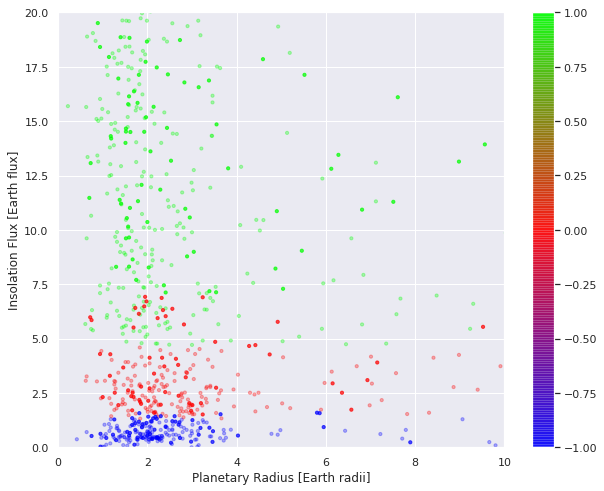

In [8]:
makeGraph(dim1, dim3)
plt.xlim(0,10)
plt.ylim(0,20)

This is all well and good, but in the above, Green represents Too Hot! And Red represents Just Right!  
This is somewhat counter-intuitive - it makes more sense for Green to be "Just Right" and Red/Blue to be Too Hot/Too Cold (respectively)  
So, I guess I need to design a new colour map!

However, I _also_ don't really need a sliding scale - because I have three categories, I only need three colours.

As such, let's try and make it work!

In [9]:
gold_colours = ((0,0,1),(0,1,0),(1,0,0))
gold_colours = ListedColormap(gold_colours)

#dim1 = "koi_prad"   <-- Already defined earlier
#dim2 = "koi_srad"   <-- Already defined earlier
#dim3 = "koi_insol"  <-- Already defined earlier

dimmap = {dim1: (0,10),
          dim2: (0,2),
          dim3: (0,20)
         }

def makeNewGraph(d1, d2):
    # Define the figure size
    plt.figure(figsize=(10,8))
    
    #Plot the Training Data
    plt.scatter(trainingX[d1], trainingX[d2], c=trainingY.values, s=10, cmap=gold_colours, alpha=0.3)
    
    # Plot the Testing Data
    plt.scatter(Xnew[d1], Xnew[d2], c=ynew, s=10, cmap=gold_colours, alpha=0.7)
    
    # Plot EARTH
    plt.plot([1.0],[1.0],"o",color='#00ff00', markeredgewidth=1.5, markersize=6, linewidth='10', markeredgecolor='black')
    
    # Set Colourbar properties
    cbar = plt.colorbar()
    cbar.set_ticks([-1,0,1])
    cbar.set_ticklabels(['Too Cold','Just Right','Too Hot'])
    #cbar
    
    # Plot the labels
    plt.xlabel(longnames[d1])
    plt.ylabel(longnames[d2])
    
    plt.xlim(dimmap[d1])
    plt.ylim(dimmap[d2])

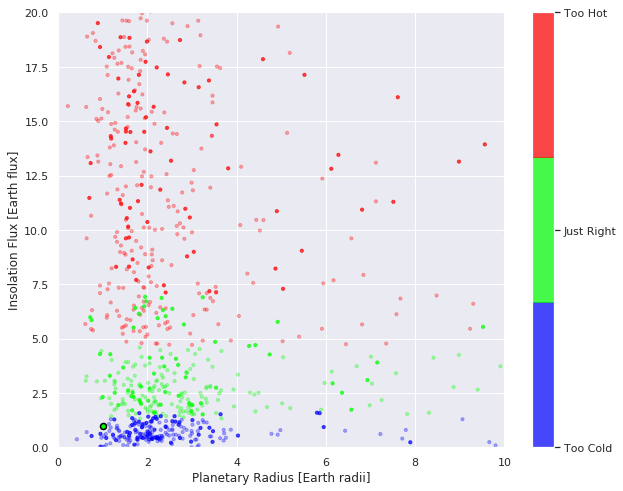

In [10]:
makeNewGraph(dim1, dim3)
#plt.xlim(0,10)
#plt.ylim(0,20)

Awesome!

In future, it might not even be necessary to have a colour bar, when I could have a Legend with three colours to label it.

This is something to muse over in the future!